<a href="https://colab.research.google.com/github/emekaokoli19/ResNet9-/blob/main/Convo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
project_name = '05-cifar10-cnn'

In [3]:
dataset_url = 'https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz'
download_url(dataset_url, '.')

  0%|          | 0/135107811 [00:00<?, ?it/s]

In [4]:
# Extract data from archive
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
  tar.extractall(path='./data')

In [5]:
data_dir = './data/cifar10'
classes = os.listdir(data_dir + '/train')

In [7]:
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = tt.Compose([
    tt.RandomCrop(32, padding=4, padding_mode='reflect'),
    tt.RandomHorizontalFlip(),
    tt.ToTensor(),
    tt.Normalize(*stats, inplace=True)
])
val_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [9]:
train_ds = ImageFolder(data_dir+'/train', train_tfms)
val_ds = ImageFolder(data_dir+'/test', val_tfms)

In [10]:
batch_size = 400
train_ds = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
val_ds = DataLoader(val_ds, batch_size*2, num_workers=3, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


GPU configuration

In [11]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

In [12]:
device = get_default_device()
device

device(type='cuda')

In [13]:
def to_device(data, device):
  # incase of list or tuple of tensors/model
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

In [14]:
class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device
  
  def __iter__(self):
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    return len(self.dl)

End of GPU configuration

In [15]:
def denormalize(images, means, stds):
  means = torch.tensor(means).reshape(1, 3, 1, 1)
  stds = torch.tensor(stds).reshape(1, 3, 1, 1)
  return images * stds + means

def show_batch(ds):
  for images, labels in ds:
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_xticks([]); ax.set_yticks([])
    denorm_images = denormalize(images, *stats)
    ax.imshow(make_grid(denorm_images[:64], nrow=16).permute(1, 2, 0).clamp(0, 1))
    break

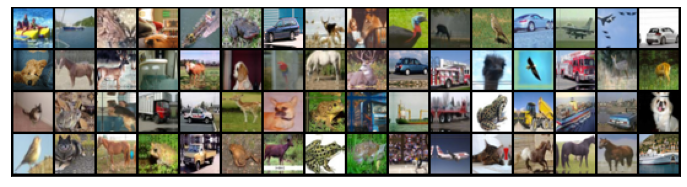

In [16]:
show_batch(train_ds)

In [19]:
class ImageClassificationBase(nn.Module):
  def training_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    return loss

  def validation_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    acc = accuracy(out, labels)
    return {'val_loss': loss.detach(), 'val_acc': acc}
  
  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

  def epoch_end(self, epoch, result):
    print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [20]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [31]:
def conv_block(in_channels, out_channels, pool=False):
  layers = [
      nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace=True)
  ]
  if pool:
    layers.append(nn.MaxPool2d(2))
  return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
  def __init__(self, in_channels, num_classes):
    super().__init__()
    self.conv1 = conv_block(in_channels, 64)
    self.conv2 = conv_block(64, 128, pool=True)
    self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
    self.conv3 = conv_block(128, 256, pool=True)
    self.conv4 = conv_block(256, 512, pool=True)
    self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
    self.classifier = nn.Sequential(
        nn.MaxPool2d(4),
        nn.Flatten(),
        nn.Dropout(0.2),
        nn.Linear(512, num_classes)
    )

  def forward(self, xb):
    out = self.conv1(xb)
    out = self.conv2(out)
    out = self.res1(out) + out
    out = self.conv3(out)
    out = self.conv4(out)
    out = self.res2(out) + out
    return self.classifier(out)

In [23]:
@torch.no_grad()
def evaluate(model, val_loader):
  model.eval()
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
  torch.cuda.empty_cache()
  optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
  sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
  history = []

  for epoch in range(epochs):
    model.train()
    train_losses = []
    lrs = []
    for batch in train_loader:
      loss = model.training_step(batch)
      train_losses.append(loss)
      loss.backward()

      # Gradient clipping
      if grad_clip:
        nn.utils.clip_grad_value_(model.parameters(), grad_clip)
      optimizer.step()
      optimizer.zero_grad()

      # update the learning rate
      lrs.append(get_lr(optimizer))
      sched.step()

    result = evaluate(model, val_loader)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    result['lrs'] = lrs
    model.epoch_end(epoch, result)
    history.append(result)
  
  return history

In [33]:
train_ds = DeviceDataLoader(train_ds, device)
val_ds = DeviceDataLoader(val_ds, device)
model = to_device(ResNet9(3, 10), device)

In [34]:
%%time
history = fit_one_cycle(10, 0.01, model, train_ds, val_ds, weight_decay=1e-4, grad_clip=0.1, opt_func=torch.optim.Adam)

Epoch [0], last_lr: 0.00278, train_loss: 1.5333, val_loss: 2.8911, val_acc: 0.3849
Epoch [1], last_lr: 0.00759, train_loss: 1.0816, val_loss: 2.2700, val_acc: 0.4186
Epoch [2], last_lr: 0.01000, train_loss: 0.8978, val_loss: 0.9157, val_acc: 0.6823
Epoch [3], last_lr: 0.00950, train_loss: 0.6828, val_loss: 0.6898, val_acc: 0.7601
Epoch [4], last_lr: 0.00812, train_loss: 0.5542, val_loss: 0.8051, val_acc: 0.7353
Epoch [5], last_lr: 0.00611, train_loss: 0.4674, val_loss: 0.4342, val_acc: 0.8533
Epoch [6], last_lr: 0.00389, train_loss: 0.3771, val_loss: 0.3761, val_acc: 0.8713
Epoch [7], last_lr: 0.00188, train_loss: 0.2967, val_loss: 0.4299, val_acc: 0.8607
Epoch [8], last_lr: 0.00050, train_loss: 0.2201, val_loss: 0.2712, val_acc: 0.9082
Epoch [9], last_lr: 0.00000, train_loss: 0.1626, val_loss: 0.2529, val_acc: 0.9162
CPU times: user 54.9 s, sys: 19.4 s, total: 1min 14s
Wall time: 5min 41s


In [35]:
def plot_accuracies(history):
  accuracies = [x['val_acc'] for x in history]
  plt.plot(accuracies, '-x')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title('Accuracy vs No. of epochs')

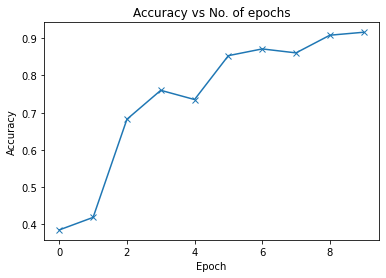

In [36]:
plot_accuracies(history)

In [37]:
def plot_losses(history):
  train_losses = [x['train_loss'] for x in history]
  val_losses = [x['val_loss'] for x in history]
  plt.plot(train_losses, '-bx')
  plt.plot(val_losses, '-rx')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['Training', 'Validation'])
  plt.title('Loss vs Number of epochs')

Check for overfitting

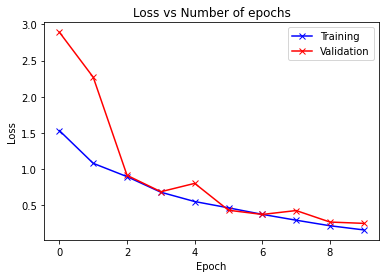

In [38]:
plot_losses(history)

In [41]:
test_ds = ImageFolder(data_dir+'/test', transform=ToTensor())

Predict labels of specific images

In [50]:
def predict_image(img, model):
  # convert to a batch of 1
  xb = to_device(img.unsqueeze(0), device)
  yb = model(xb)
  # pick index with highest probability
  _, preds = torch.max(yb, dim=1)
  return test_ds.classes[preds[0].item()]

Label: airplane , Predicted: airplane


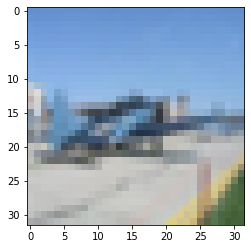

In [54]:
img, label = test_ds[69]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_ds.classes[label], ', Predicted:', predict_image(img, model))

In [57]:
torch.save(model.state_dict(), 'cifar10-cnn.pth')

#model_load = to_device(ResNet9(3, 9), device)

#model_load.load_state_dict(torch.load('cifar10-cnn.pth'))

torch.save(model.state_dict(), 'cifar10-cnn.pth')

model_load = to_device(Cifar10CnnModel(), device)

model_load.load_state_dict(torch.load('cifar10-cnn.pth'))